In [261]:
import pandas as pd
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import requests
from statsmodels.tsa.arima.model import ARIMA
import time

In [282]:
df = pd.read_csv("temperature_data.csv")

# Анализ временных рядов

Вычисление скользящего среднего и стандартного отклонения для сглаживания температурных колебаний.

In [285]:
def prepare_city(df : pd.DataFrame, city : str, window_size : int = 30) -> pd.DataFrame:
        buf = df[df['city'] == city]
        buf[f'smooth_30_mean'] = buf['temperature'].rolling(window_size).mean()
        buf[f'smooth_30_std'] = buf['temperature'].rolling(window_size).std()
        buf['is_anomaly'] = (buf['smooth_30_mean'] - 2*buf['smooth_30_std'] > buf['temperature']) | (buf['smooth_30_mean'] + 2*buf['smooth_30_std'] < buf['temperature'])        
        buf['max_temperature'] = buf['temperature'].max()
        buf['min_temperature'] = buf['temperature'].min()
        buf['mean_temperature'] = buf['temperature'].mean()
        buf['std_temperature'] = buf['temperature'].std()

        y = np.array(df[df['city'] == city]['temperature'])
        model = ARIMA(y, order=(2, 3, 3)) 
        results = model.fit()
        pred = results.forecast(steps=10)
        return buf, pred

def get_profile_season(df : pd.DataFrame) -> dict:
        def to_integer(dt_time):
            return 10000*dt_time.year + 100*dt_time.month + dt_time.day
        
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        group = df[['timestamp', 'temperature',	'season']].groupby(['season', 'timestamp']).mean()
        group['season'] = [elem[0] for elem in group.index]
        group['timestamp'] = [elem[1] for elem in group.index]
        group = group.reset_index(drop=True)
        model = LinearRegression()
        dt_season = dict()

        for season in group['season'].unique():
            df_season = group[group['season'] == season].copy()

            X = pd.to_datetime(df_season[df_season['season'] == season]['timestamp']).apply(lambda x: to_integer(x))
            model.fit(np.array(X).reshape(-1, 1), df_season[df_season['season'] == season]['temperature'])
            df_season['pred'] = model.predict(np.array(X).reshape(-1, 1))
            df_season['trend_coef'] = model.coef_[0]

            df_season['avg_temp'] = df_season['temperature'].mean()
            df_season['std_temp'] = df_season['temperature'].std()

            dt_season[season] = df_season

        return dt_season

data = prepare_city(df, 'Moscow')
data_season = get_profile_season(df)

# распараллелим с помощью joblib

*проверка прироста в скорости до добавления модели ARIMA*

In [273]:
from joblib import Parallel, delayed
    
cities = df['city'].unique()
num_cores = [i for i in range(1,9)]
times = []

for num_core in num_cores:
    start = time.time()
    results = Parallel(n_jobs=num_core)(delayed(prepare_city)(df, c) for c in cities)
    times.append(time.time()-start)

C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1424510659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buf[f'smooth_30_mean'] = buf['temperature'].rolling(window_size).mean()
C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1424510659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buf[f'smooth_30_std'] = buf['temperature'].rolling(window_size).std()
C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1424510659.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

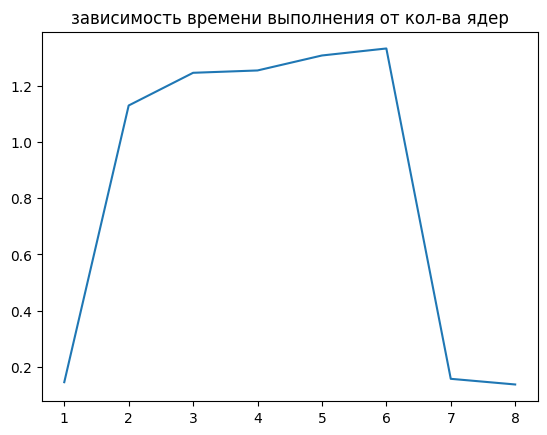

In [274]:
plt.plot(num_cores, times)
plt.title("зависимость времени выполнения от кол-ва ядер")
plt.show()

In [275]:
start = time.time()
df_lst = []
for city in cities:
    df_lst.append(prepare_city(df, city))
times = time.time()-start

C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1424510659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buf[f'smooth_30_mean'] = buf['temperature'].rolling(window_size).mean()
C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1424510659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buf[f'smooth_30_std'] = buf['temperature'].rolling(window_size).std()
C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1424510659.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [276]:
print(times)

0.1369926929473877


*проверка прироста в скорости ПОСЛЕ добавления модели ARIMA*

In [279]:
start = time.time()
results = Parallel(n_jobs=-1)(delayed(prepare_city)(df, c) for c in cities)
times = time.time()-start
print(times)

10.450025796890259


In [280]:
start = time.time()
df_lst = []
for city in cities:
    df_lst.append(prepare_city(df, city))
times = time.time()-start

C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1493444908.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buf[f'smooth_30_mean'] = buf['temperature'].rolling(window_size).mean()
C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1493444908.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buf[f'smooth_30_std'] = buf['temperature'].rolling(window_size).std()
C:\Users\Vitaliy\AppData\Local\Temp\ipykernel_17352\1493444908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [281]:
print(times)

64.40986967086792


# сравнение requests и aiohttp

In [225]:
start = time.time()
lst_temp = []
api_key = 'e0ad4718aa5dbe6b4d4c37d9503b3337'
for selected_city in df['city'].unique():
    url = f"https://api.openweathermap.org/data/2.5/weather?q={selected_city}&appid={api_key}"
    response = requests.get(url)
    lst_temp.append(response.json()['main']['temp'] - 273.15)

print(time.time()-start)

3.870760917663574


In [232]:
import asyncio
import aiohttp
import nest_asyncio
nest_asyncio.apply()

async def fetch(session, city):
    api_key = 'e0ad4718aa5dbe6b4d4c37d9503b3337' 
    url = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"
    
    async with session.get(url) as response:
        return await response.json()

async def main(df):
    async with aiohttp.ClientSession() as session:
        tasks = []
        
        for selected_city in df['city'].unique():
            task = asyncio.create_task(fetch(session, selected_city))
            tasks.append(task)
            
        results = await asyncio.gather(*tasks)
        return results

start = time.time()
lst = asyncio.run(main(df))
print(time.time()-start)

0.28824329376220703


`Вывод: распараллеливание функции с помощью joblib проводилось в 2 ситуациях: с обучением модели arima и без. до добавления аримы: построен график скорости выполнения на ядрах от 1 до 8 и наивысшая скорость достигается на одном ядре (либо без joblib), интересно, что при обработке на 7 и 8 ядрах скорость такая же как и на 1 ядре. На одном ядре скорость 0.14 секунды, а при кол-ве ядер от 2 до 6 скорость работы 1.2 секунды. Но! после того как я решил добавить в функцию обучение и предсказание модели арима joblib дал невероятный прирост скорости! Без распараллеливания фнкция выполнялась 64 секунды, а после распараллеливния всего 10 секунд `

 `Использование aiohttp дало высокий прирост в скорости: при использовании requests все запросы к api (текущая температура в конкретном городе) обрабатывались за 3.87 секунды, а при использовании aiohttp скорость достигает 0.28 секунды!`